In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf

In [2]:
survey_df = pd.read_csv('../data/cleaned-online-v1-prolific-sample.csv')
survey_df.head(3)

,Duration (in seconds),RecordedDate,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,...,Q_live_urban,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,STUDY_ID,treatment
0,123,2022-06-28 09:32:52,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,2,1,NaN,4,1,6,1,NaN,62bb1ba7f2c710e36fd2c1be,labeled
1,231,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,0.0,0.0,0.0,1.0,0.0,NaN,NaN,...,2,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,62bb1ba7f2c710e36fd2c1be,unlabeled
2,239,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1,2,NaN,5,2,2,1,"None, but thank you!",62bb1ba7f2c710e36fd2c1bf,labeled


In [3]:
print(list(survey_df.columns))

['Duration (in seconds)', 'RecordedDate', 'ResponseId', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'STUDY_ID', 'treatment']


## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled (1/0), QID, menu, choice type (1-5), choice (1/0) 
```

In [4]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [5]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'Duration (in seconds)', 'RecordedDate',
    # removed during preprocessing:
    # 'PROLIFIC_PID',
    # 'Finished',
    # 'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway',
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [6]:
respondent_df = survey_df[respondent_columns].copy()
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=759 total responses before data cleaning


,ResponseId,Duration (in seconds),RecordedDate,Q_current_hunger,Q_live_urban,Q_work_urban,Q_politics,Q_US_state,Q_priorities_1,Q_priorities_2,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
0,R_125SdSXI0xLI29S,123,2022-06-28 09:32:52,3,2,1,3,22,4,5,...,4,4,2,4,4,1,6,1,NaN,labeled
1,R_23V4Eyckqxl6Bmy,231,2022-06-28 09:34:23,2,2,2,3,22,2,3,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
2,R_2c5wLF9HxTeZ30h,239,2022-06-28 09:35:35,2,1,2,1,20,2,3,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


### Codebook

In [7]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [8]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'health','2':'cost','3':'taste','4':'filling','5':'usual_choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [9]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

10      1
15      1
38      1
42      1
1       1
17      1
31      2
23      2
48      3
45      4
39      4
5       7
47     29
33     30
41     54
30     54
20     65
7     143
22    356
Name: Q_US_state, dtype: int64


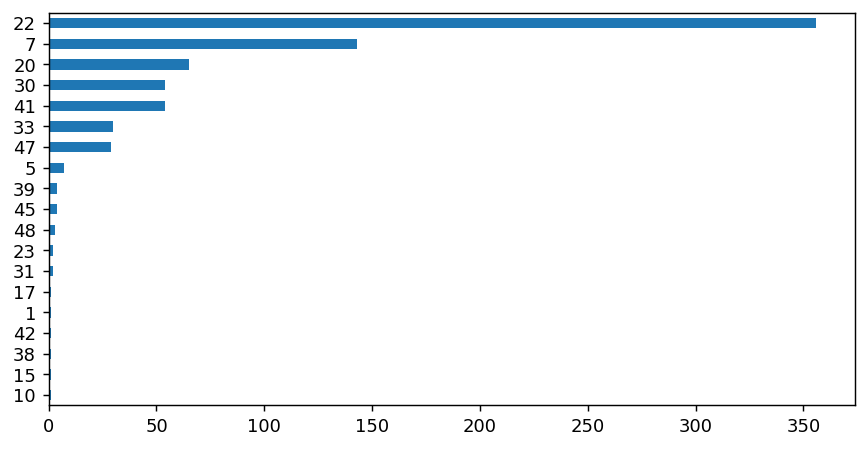

In [10]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(8,4), dpi=130)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

Count the self-reported vegans and vegetarians and exclude them from analysis.


(For respondents who selected one option)
None           613
Vegetarian      43
Other           38
Pescatarian     20
Keto            13
Vegan            9
Gluten free      8
Name: Q_special_diet, dtype: int64


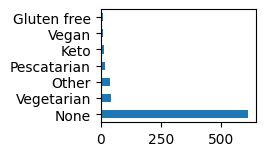

In [11]:
# '1':'Keto','2':'Pescatarian','3':'Vegetarian','4':'Gluten free','5':'Vegan','6':'Other','7':'None'
fig,ax = plt.subplots(figsize=(2,1.5), dpi=100)
# Not these value counts only include responses that selected one choice
print('(For respondents who selected one option)')
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh(ax=ax)
plt.show()
# print(respondent_df['Q_special_diet'].value_counts())

Separate the vegan/vegetarian respondents from the others

In [12]:
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)

veg_respondent_df = respondent_df[(respondent_df['is_vegetarian'] + respondent_df['is_vegan']) > 0]

print('total vegetarians and vegans (some overlap with participants reporting both): %s' % (len(veg_respondent_df)))
print('vegetarin: %s' % respondent_df['is_vegetarian'].sum())
print('vegan: %s' % respondent_df['is_vegan'].sum())

total vegetarians and vegans (some overlap with participants reporting both): 61
vegetarin: 51
vegan: 13


In [13]:
len(respondent_df[(respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)])

698

In [14]:
print('dropping vegans and vegetarians from main sample')
respondent_df = respondent_df[
    (respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)
].drop(['is_vegan','is_vegetarian'], axis=1)
N = len(respondent_df)
print('resulting N=%s' % N)

dropping vegans and vegetarians from main sample
resulting N=698


In [15]:
"""
Make a table representing aggregate characteristics of the sample

characteristic, count or mean, (%) or (std) 
"""

sample_characteristics_cols = ['characteristic', 'count or mean', '(%) or (std)']
sample_aggregate_characteristics_df = pd.DataFrame({}, columns=sample_characteristics_cols)
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)


                      count   (%)
gender                           
Female                  376  53.9
Male                    303  43.4
Other                    17   2.4
Prefer not to answer      2   0.3


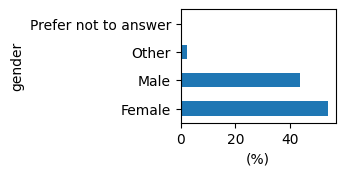

In [16]:
respondent_df['gender'] = respondent_df.Q_demos_gender.astype(str).map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(2,1.5),dpi=100)
gender_counts = respondent_df.groupby(
    'gender'
)['ResponseId'].count().rename('count').to_frame()
gender_counts['(%)'] = 100*round(gender_counts['count']/gender_counts['count'].sum(), 3)
print(gender_counts)
gender_counts['(%)'].plot.barh(ax=ax)
_ = ax.set_xlabel('(%)')

We code gender as a binary of male vs non-male

In [17]:
respondent_df['male'] = respondent_df['gender'].apply(lambda g: 1 if g =='Male' else 0)

In [18]:
gender_df = pd.DataFrame([
    ['Male',  respondent_df.male.sum(), round(100*respondent_df.male.sum()/N, 2)]],
    columns=sample_characteristics_cols,
)
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df,gender_df])

How old are you?


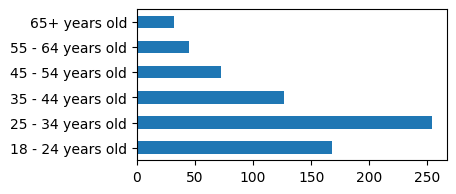

,index,count,pct
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58


In [19]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(4,2), dpi=100)
_ = respondent_df['Q_demos_age'].astype(str).value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
plt.show()
age_df = (respondent_df['Q_demos_age'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_age']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
age_df

In [20]:
age_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df, 
    pd.DataFrame([['Age', '','']], columns=sample_characteristics_cols),
    age_df
])

What was your total household income before taxes during the past 12 months?



,index,count,pct
0,"Less than \$25,000",82,11.75
1,"\$25,000 to \$49,999",143,20.49
2,"\$50,000 to $74,999",133,19.05
3,"\$75,000 to \$99,999",120,17.19
4,"\$100,000 to $149,999",113,16.19
5,"\$150,000 or more",81,11.60
6,Prefer not to say,26,3.72


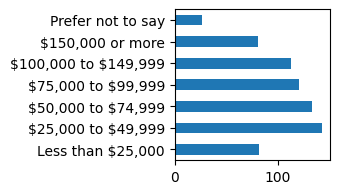

In [21]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(2,2), dpi=100)
_ = respondent_df['Q_demos_income'].astype(str).value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)

income_df = (respondent_df['Q_demos_income'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_income']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
income_df

In [22]:
income_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Household income', '','']], columns=sample_characteristics_cols),
    income_df
])

Race

Note 2019 census estimates for MA have White alone at 80%

https://www.census.gov/quickfacts/MA

According to ACS 2018, White Americans are 80.7% of New England. [(From wikipedia)](https://en.wikipedia.org/wiki/Demographics_of_New_England#:~:text=In%20terms%20of%20race%20and,people%20of%20non%2DHispanic%20origin.)

,index,count,pct
0,White or Caucausian,569,81.52
1,Other,55,7.88
2,Asian,44,6.30
3,Black or African American,27,3.87
4,Native Hawaiian or Other Pacific Islander,2,0.29
5,American Indian/Native American or Alaska Native,1,0.14


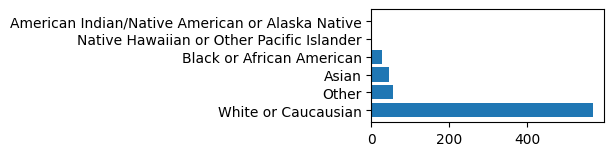

In [23]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
# print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
race_df = (respondent_df['race'].value_counts().sort_values(ascending=False)
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
fig,ax = plt.subplots(1,1,figsize=(3,1.5),dpi=100)
_ = ax.barh(race_df['index'], race_df['count'])
race_df

Which of the following best describes your political preference?
{'1': 'Strongly Democratic', '2': 'Democratic', '3': 'Lean Democratic', '4': 'Lean Republican', '5': 'Republican', '6': 'Strongly Republican'}


,count
Strongly Democratic,184
Democratic,201
Lean Democratic,185
Lean Republican,91
Republican,28
Strongly Republican,9


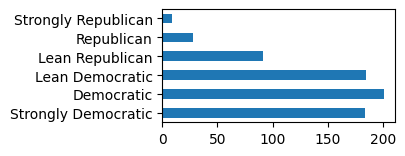

In [24]:
print('%s\n%s' % (codebook['Q_politics']['Q'], codebook['Q_politics']['choices']))
fig,ax = plt.subplots(figsize=(3,1.5),dpi=100)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).rename('count').to_frame()

Which best describes the area you live?


,count
Suburban,401
Urban,185
Rural,112


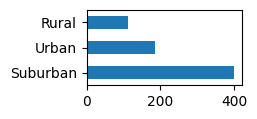

In [25]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).rename('count').to_frame()

Do you work in an urban area?


,count
No,412
Yes,264
Not sure / Other,22


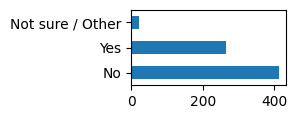

In [26]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).rename('count').to_frame()

How would you rank your current hunger level on a scale from 1 - 4?
1    132
2    278
3    228
4     60
Name: Q_current_hunger, dtype: int64


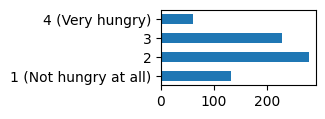

In [27]:
print(codebook['Q_current_hunger']['Q'])
fig,ax = plt.subplots(figsize=(2,1), dpi=100)
respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index().rename(codebook['Q_current_hunger']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index())

Transform (1-4) values from strings to integers

In [28]:
respondent_df['Q_current_hunger'] = respondent_df['Q_current_hunger'].astype(int)

In [29]:
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df ,pd.DataFrame(
    [['current hunger (1 - 4)', 
        respondent_df['Q_current_hunger'].mean(), 
        respondent_df['Q_current_hunger'].std()]],
    columns=sample_characteristics_cols
)])
# sample_aggregate_characteristics_df

In [30]:
print(codebook['Q_priorities']['Q'])
print(codebook['Q_priorities']['choices'])

How do you prioritize the following when choosing what to order for yourself off a menu?
{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}


Transform from string to integer values

In [31]:
for p in codebook['Q_priorities']['choices'].keys():
    respondent_df['Q_priorities_%s'%p] = respondent_df['Q_priorities_%s'%p].astype(int)

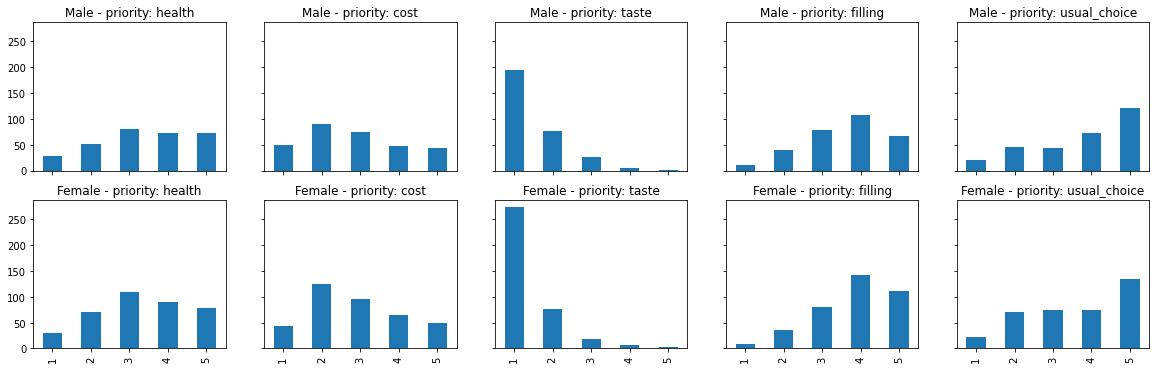

In [32]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)

In [33]:
pkeys = list(codebook['Q_priorities']['choices'].keys())
priorities_df = pd.DataFrame({
    'priority': list(codebook['Q_priorities']['choices'].values()),
    'mean': [respondent_df['Q_priorities_%s'%p].mean() for p in pkeys],
    '(std)': [respondent_df['Q_priorities_%s'%p].std() for p in pkeys],
}, index=pkeys).sort_values('mean')
priorities_df

,priority,mean,(std)
3,taste,1.434097,0.733957
2,cost,2.829513,1.247501
1,health,3.353868,1.235298
5,usual_choice,3.653295,1.311081
4,filling,3.729226,1.050943


In [34]:
priorities_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Relative importance when choosing off a menu', '','']], columns=sample_characteristics_cols),
    priorities_df
])

How often does each priority occur as a top priority?

In [35]:
top_priority_df = (
    pd.DataFrame({
        'priority': list(codebook['Q_priorities']['choices'].values()),
        'count':[respondent_df['Q_priorities_%s'%p].apply(lambda p: p==1).sum() for p in pkeys],
    })
    .assign(pct=lambda x: round(100*x['count']/N, 2))
    .sort_values('pct', ascending=False)
)
top_priority_df

,priority,count,pct
2,taste,475,68.05
1,cost,100,14.33
0,health,57,8.17
4,usual_choice,47,6.73
3,filling,19,2.72


In [36]:
top_priority_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Top priority when choosing off a menu', '','']], columns=sample_characteristics_cols),
    top_priority_df
])
# sample_aggregate_characteristics_df

In [37]:
print(codebook['Q_past_vegetarian']['Q'])
print(codebook['Q_past_vegan']['Q'])

In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?
In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)


In [38]:
respondent_df['Q_past_vegetarian'] = respondent_df['Q_past_vegetarian'].astype(int)
respondent_df['Q_past_vegan'] = respondent_df['Q_past_vegan'].astype(int)

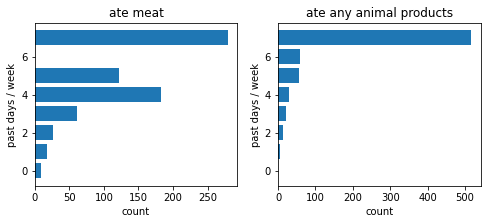

In [39]:
past_days_diet_df = respondent_df['Q_past_vegetarian'].value_counts().sort_index().rename('ate meat').to_frame()
past_days_diet_df.loc[6] = 0
past_days_diet_df = past_days_diet_df.sort_index()
past_days_diet_df.rename_axis('days/week')
past_days_diet_df['ate any animal products'] = respondent_df['Q_past_vegan'].value_counts().sort_index()
fig,axes = plt.subplots(1,2,figsize=(8,3))#, sharey=True)
axes[0].barh(past_days_diet_df.index, past_days_diet_df['ate meat'])
axes[1].barh(past_days_diet_df.index, past_days_diet_df['ate any animal products'])
axes[0].set_title('ate meat')
axes[1].set_title('ate any animal products')
axes[0].set_ylabel('past days / week')
axes[0].set_xlabel('count')
axes[1].set_ylabel('past days / week')
_ = axes[1].set_xlabel('count')
# past_days_diet_df

In [40]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([
        ['Past days/week ate meet', respondent_df['Q_past_vegetarian'].mean(), respondent_df['Q_past_vegetarian'].std()],
        ['Past days/week ate any animal products', respondent_df['Q_past_vegan'].mean(), respondent_df['Q_past_vegan'].std()]
    ], columns=sample_characteristics_cols)
])

How strongly do you agree with the following statement?
"Vegan dishes are not for people like me."



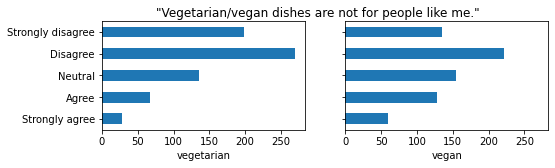

In [41]:
print('%s\n'%codebook['Q_vegan_not_me']['Q'])
fig,axes = plt.subplots(1,2,figsize=(8,2),sharey=True,sharex=True)
fig.suptitle('"Vegetarian/vegan dishes are not for people like me."')
respondent_df['Q_vegetarian_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegetarian_not_me']['choices']).plot.barh(ax=axes[0])
axes[0].set_xlabel("vegetarian")
respondent_df['Q_vegan_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegan_not_me']['choices']).plot.barh(ax=axes[1])
_ = axes[1].set_xlabel("vegan")

In [42]:
def collapse_categories_5_to_3(resp):
    """Maps 5 point scale to 3 point scale: Maps 1-2 -> 1; 3 -> 2; 3-4 -> 3"""
    if resp < 3:
        return 1
    if resp == 3:
        return 2
    return 3

reduced_agree_neutral_disagree_map = {
    1: 'Strongly agree or agree',
    2: 'Neutral',
    3: 'Disagree or strongly disagree'
}
def map_agree_neutral_disagree(resp):
    return reduced_agree_neutral_disagree_map[resp]

reduced_importance_map = {
    1: 'Not important',
    2: 'Neutral',
    3: 'Important'
}

In [43]:
vegetarian_not_me_df = (
    respondent_df['Q_vegetarian_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegetarian_not_me_df.columns = sample_characteristics_cols
vegetarian_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,95,13.61
1,Neutral,135,19.34
2,Disagree or strongly disagree,468,67.05


In [44]:
vegan_not_me_df = (
    respondent_df['Q_vegan_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegan_not_me_df.columns = sample_characteristics_cols
vegan_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,188,26.93
1,Neutral,154,22.06
2,Disagree or strongly disagree,356,51.00


In [45]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['"Vegetarian dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegetarian_not_me_df,
    pd.DataFrame([['"Vegan dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegan_not_me_df,
])

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       151
Agree                325
Neutral              197
Disagree              17
Strongly disagree      8
Name: Q_good_for_env, dtype: int64


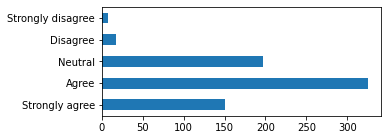

In [46]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

How important is environmental sustainability to you as an issue?
Very much not important     21
Not important               37
Neutral                     71
Somewhat important         319
Very important             250
Name: Q_how_important_env, dtype: int64


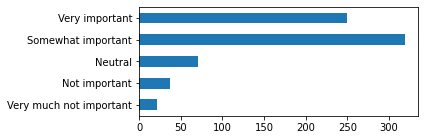

In [47]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

In [48]:
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)
0,Male,303,43.41
0,Age,,
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58
0,Household income,,
0,"Less than \$25,000",82,11.75


More correlations between covariates

In [49]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


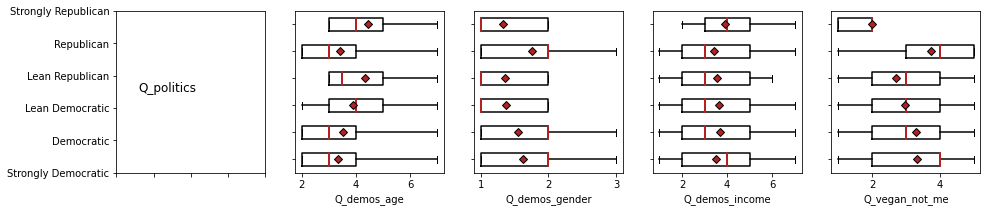

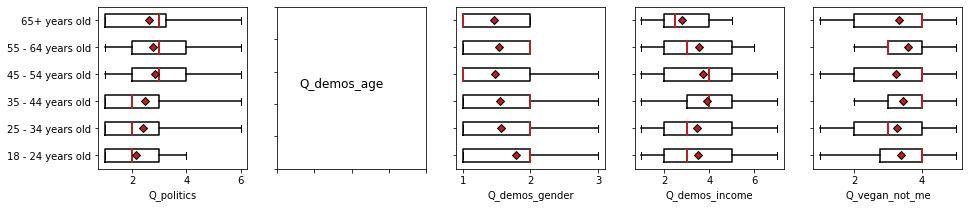

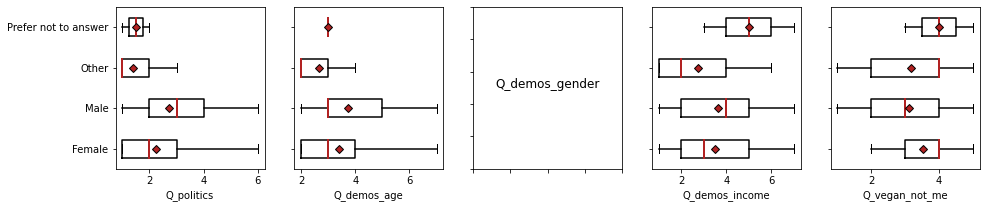

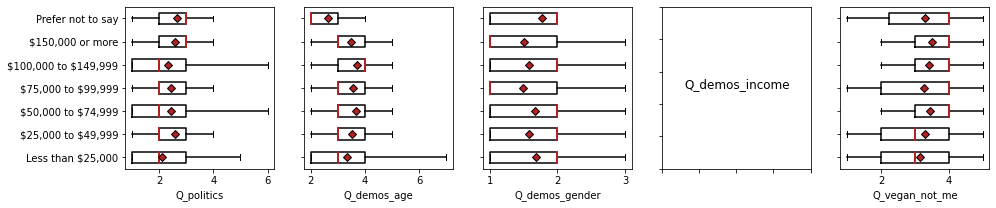

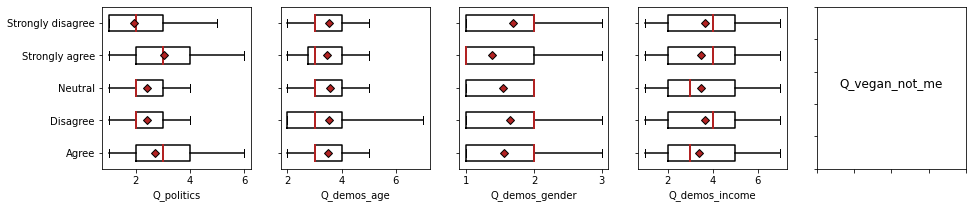

In [50]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy().astype(str)


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

### Menu choices table

```
ResponseId, labeled (0/1), QID, menu, choice_type (1-5), choice (1,2) 
```

In [51]:
# choices_df excludes vegetarian/vegan respondents.
# veg_choices_df only includes them.

# Wide data
choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention checks or are veg
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(respondent_df['ResponseId']))
]
choices_wide_df.head(3)
assert(len(respondent_df) == len(choices_wide_df))

In [52]:
# Create a separate dataframe for respondents who are veg
# Start wide wide data
veg_choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention; keep only veg
veg_choices_wide_df = veg_choices_wide_df[
    (veg_choices_wide_df.ResponseId.isin(veg_respondent_df['ResponseId']))
]
assert(len(veg_respondent_df) == len(veg_choices_wide_df))

In [53]:
def transform_choices_data(wide_df):
    # Transform from wide to long data
    choices_df = pd.melt(wide_df, id_vars=['ResponseId'], value_vars=choice_Qs, 
                 var_name='QID', value_name='choice')
    # Add Q data
    # ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
    # code choice, choice_type, labeled as numeric
    choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
    choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
    # only keep responses for answered questions
    # this should equal half of the total questions
    assert(0.5 == len(choices_df.dropna())/len(choices_df))
    choices_df = choices_df.dropna()
    choices_df['choice'] = choices_df['choice'].astype(int)
    return choices_df

In [54]:
choices_df = transform_choices_data(choices_wide_df)
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


In [55]:
# transform to long data
veg_choices_df = transform_choices_data(veg_choices_wide_df)
assert(len(veg_choices_df) == len(veg_respondent_df) * 5) # 5 Qs per respondent
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0


Choices data

In [56]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

Add in information about choice attributes

In [57]:
# code whether choice has meat
choices_df['option_w_meat'] = choices_df['choice_type'].apply(lambda c: 1 if c in [1,2] else 0)
choices_df['choice_vegetarian'] = choices_df['choice_type'].apply(lambda c: 1 if c in [1,3] else 0)
choices_df['choice_vegan'] = choices_df['choice_type'].apply(lambda c: 1 if c in [2,4,5] else 0)

In [58]:
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,1,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,1,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0,1,1,0


### Respondent level variables

gender

In [59]:
# Coding gender as Male: 0.5; Otherwise: -0.5
choices_df['gender'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['gender']
).apply(lambda g: 0.5 if g=='Male' else -0.5)

# Coding male as Male: 1; Otherwise: 0
choices_df['male'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['gender']
).apply(lambda g: 1 if g=='Male' else 0)

Other basic demographics to control for

In [60]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age']).astype(str)
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income']).astype(str)

Hunger

In [61]:
choices_df['current_hunger'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_current_hunger']
)

"vegan / vegetarian dishes not for people like me"

Binary coded as 1 if they strongly agree (1) or agree (2)

In [62]:
codebook['Q_vegan_not_me']['choices']

{'1': 'Strongly agree',
 '2': 'Agree',
 '3': 'Neutral',
 '4': 'Disagree',
 '5': 'Strongly disagree'}

In [63]:
choices_df['vegetarian_not_me'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_vegetarian_not_me'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)
choices_df['vegan_not_me'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_vegan_not_me'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)

Binary code whether they say agree the environment is important.

1: important or very important; 0: neutral or not important or very much not important

In [64]:
# code as 0: not important or neutral; 1: important
print(codebook['Q_how_important_env']['Q'])
print(codebook['Q_how_important_env']['choices'])
choices_df['env_is_important'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_how_important_env'].astype(int)
).apply(lambda r: 0 if r < 4 else 1)

How important is environmental sustainability to you as an issue?
{'1': 'Very much not important', '2': 'Not important', '3': 'Neutral', '4': 'Somewhat important', '5': 'Very important'}


Binary code for whether respondents agree vegetarian/vegan dishes are good for the environment.

1: agree or strongly agree; 0: neutral or disagree or strongly disagree

In [65]:
# code veg_good_for_env as 0: disagree or neutral; 1: agree
print('%s'%codebook['Q_good_for_env']['Q'])
print(codebook['Q_good_for_env']['choices'])
choices_df['veg_good_for_env'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_good_for_env'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."
{'1': 'Strongly agree', '2': 'Agree', '3': 'Neutral', '4': 'Disagree', '5': 'Strongly disagree'}


Priorities

In [66]:
print(codebook['Q_priorities']['Q'])
print(codebook['Q_priorities']['choices'])
print('1 is top priority')

How do you prioritize the following when choosing what to order for yourself off a menu?
{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}
1 is top priority


Priority values are flipped and recentered on a -2, -1, 0, 1, 2, 3 scale; higher value indicates higher priority.

e.g. 1 -> 2; 2 --> 1; 3 --> 0; 4--> -1; 5 --> -2

In [67]:
# put in column to choices df as priority_pname;
for pkey, pname in codebook['Q_priorities']['choices'].items():
    # recoded as (3 - value) so that higher value means higher priority; priority=3: 0
    choices_df['priority_%s'%pname] = choices_df['ResponseId'].map(
        3 - respondent_df.set_index('ResponseId')['Q_priorities_%s'%pkey]
    )

For each priority: add in boolean indicating whether it is the top 1 priority.
(Also previously tested with whether was in top 2 priorities and was not
interesting.)

In [68]:
for pkey, pname in codebook['Q_priorities']['choices'].items():
    choices_df['top_1_priority_%s'%pname] = choices_df['ResponseId'].map(
        respondent_df.set_index('ResponseId')['Q_priorities_%s'%pkey]
    ).apply(lambda p: 1 if p == 1 else 0)

In [69]:
choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan,gender,male,...,priority_health,priority_cost,priority_taste,priority_filling,priority_usual_choice,top_1_priority_health,top_1_priority_cost,top_1_priority_taste,top_1_priority_filling,top_1_priority_usual_choice
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,1,0,2,-2,-1,0,0,1,0,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,0,2,1,-1,-2,0,1,0,0,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,0,-1,2,-2,1,0,0,1,0,0


##### Veg choices data

For the vegetarian choices data, add in who is vegan vs vegetarian so that can properly test choice type 5.

In [70]:
for is_v in ['is_vegetarian', 'is_vegan']:
    veg_choices_df[is_v] = veg_choices_df.ResponseId.map(veg_respondent_df.set_index('ResponseId')[is_v])
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,is_vegetarian,is_vegan
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0,1,1
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0,1,0


## Analysis

### Plots and Chi-Squared tests

In [71]:
# For plotting
plot_choices_type_names_dict = {
    1:'(1) vegetarian vs (2) meat',
    2:'(1) vegan vs (2) meat',
    3:'(1) vegetarian vs (2) vegetarian',
    4:'(1) vegan vs (2) vegan',
    5:'(1) vegan vs (2) vegetarian',
}

In [72]:
def make_contingency_df(df):
    """
    Make tables like:
    ```
    choice, labeled, unlabeled, (%) labeled, (%) unlabeled, expected (based on unlabeled)
    0    A           B
    1    C           D
    total
    ```
    """
    contingency_df = pd.DataFrame({
        'labeled': df[df['labeled']==1]['choice'].value_counts(),
        'unlabeled': df[df['labeled']==0]['choice'].value_counts(),
    }, index=[0, 1]).rename_axis('choice').fillna(0)
    contingency_df.loc['total'] = [contingency_df[c].sum() for c in contingency_df.columns]
    for l in ['labeled', 'unlabeled']:
        contingency_df['%% %s'%l] = contingency_df[l]/contingency_df[l]['total']
    contingency_df['expected'] = (
        contingency_df['labeled']['total'] * contingency_df['% unlabeled']
    )
    return contingency_df

In [73]:
choices_all_contingency_df = make_contingency_df(choices_df)
choices_all_contingency_df

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,0.665698,0.633333,1089.333333
1,575,649,0.334302,0.366667,630.666667
total,1720,1770,1.000000,1.000000,1720.000000


In [74]:
def plot_contingency_table(df, ax, legend_labels=['option 2','option 1'], ylabel=True, legend=True):
    n_labels_values = df.loc['total'][['labeled', 'unlabeled']]
    labels = ['%s\n(n=%s)'%(l, int(n)) for l, n in n_labels_values.iteritems()]
    #labels = ['labeled', 'unlabeled'] # a simpler labeling
    option1_values = 100*df[['% labeled', '% unlabeled']].loc[1]
    option2_values = 100*df[['% labeled', '% unlabeled']].loc[0]

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    rects1 = ax.bar(x - width/2, option1_values, width, 
                    linewidth=1, edgecolor='black',
                    color='lightgray', label=legend_labels[1])
    rects2 = ax.bar(x + width/2, option2_values, width, 
                    linewidth=1, edgecolor='black',
                    color='white', label=legend_labels[0])
    ax.set_ylim(0, 108)
    if ylabel: ax.set_ylabel('% chosen')
    ax.set_xticks(x, labels)
    option1_labels = ['%0.1f%%'%v for v in round(option1_values, 1)]
    option2_labels = ['%0.1f%%'%v for v in round(option2_values, 1)]
    ax.bar_label(rects1, option1_labels, padding=3)
    ax.bar_label(rects2, option2_labels, padding=3)
    if legend: ax.legend()

chisq = 7.758; p=0.021


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,0.665698,0.633333,1089.333333
1,575,649,0.334302,0.366667,630.666667
total,1720,1770,1.000000,1.000000,1720.000000


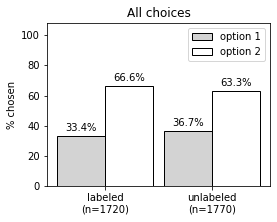

In [75]:
figsize=(4,3)
fig,ax = plt.subplots(figsize=figsize)
plot_contingency_table(choices_all_contingency_df, ax)
chisq, p = scipy.stats.chisquare(
    choices_all_contingency_df['labeled'], 
    choices_all_contingency_df['expected']
)
print('chisq = %0.3f; p=%0.3f' % (chisq, p))
ax.set_title('All choices')
choices_all_contingency_df

Plot choice 5 only

chisq = 4.628; p=0.099


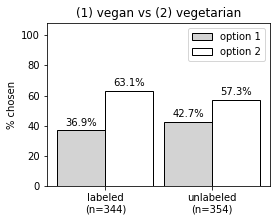

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,217,203,0.630814,0.573446,197.265537
1,127,151,0.369186,0.426554,146.734463
total,344,354,1.000000,1.000000,344.000000


In [76]:
c5df = choices_df[choices_df['choice_type']==5]
c5_contingency_df = make_contingency_df(c5df)
chisq, p = scipy.stats.chisquare(
    c5_contingency_df['labeled'], 
    c5_contingency_df['expected']
)
fig,ax = plt.subplots(figsize=figsize)
plot_contingency_table(c5_contingency_df, ax)
print('chisq = %0.3f; p=%0.3f' % (chisq, p))
ax.set_title('%s'%(plot_choices_type_names_dict[5]))
plt.show()
c5_contingency_df

Plots for all choice types separately

1: (1) vegetarian vs (2) meat
chisq = 7.908; p=0.019


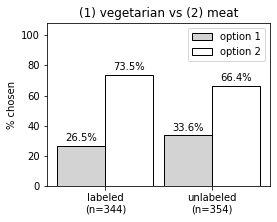

2: (1) vegan vs (2) meat
chisq = 0.123; p=0.941


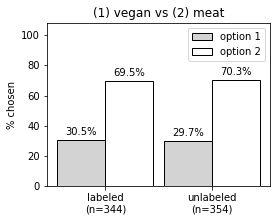

3: (1) vegetarian vs (2) vegetarian
chisq = 0.378; p=0.828


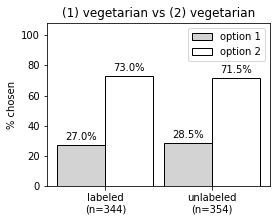

4: (1) vegan vs (2) vegan
chisq = 0.966; p=0.617


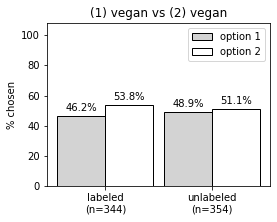

5: (1) vegan vs (2) vegetarian
chisq = 4.628; p=0.099


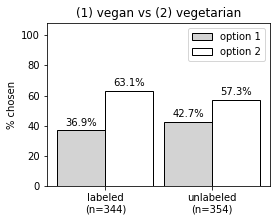

In [77]:
for choice_type, name in plot_choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'], 
        c_contingency_df['expected']
    )
    fig,ax = plt.subplots(figsize=figsize)
    plot_contingency_table(c_contingency_df, ax)
    print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    ax.set_title('%s'%(name,))
    plt.show()

In [78]:
# by male vs non-male
male_choices_df = choices_df[choices_df['male'] == 1]
nonmale_choices_df = choices_df[choices_df['male'] < 1]

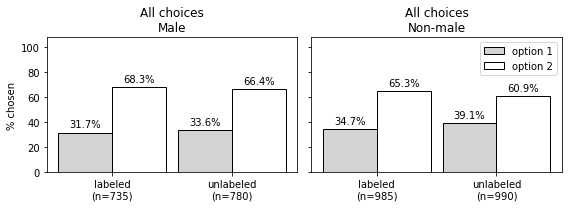

In [79]:
fig,axes = plt.subplots(1,2, figsize=(8,3), sharey=True) # do not share x because n different
plt.tight_layout()
for i, (g, df) in enumerate([('Male',male_choices_df),('Non-male',nonmale_choices_df),]):
    ax = axes[i]
    ax.set_title(g)
    contingency_df = make_contingency_df(df)
    plot_contingency_table(contingency_df, ax,
                           ylabel=(True if i==0 else False), 
                           legend=(True if i>0 else False))
    ax.set_title('%s\n%s'%('All choices', g))
fig.tight_layout()

1: (1) vegetarian vs (2) meat


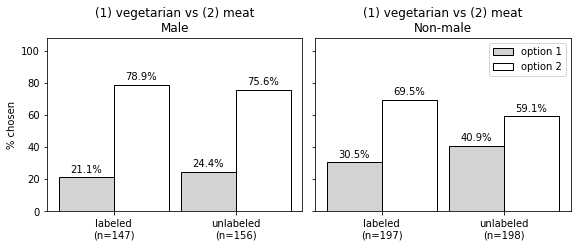

2: (1) vegan vs (2) meat


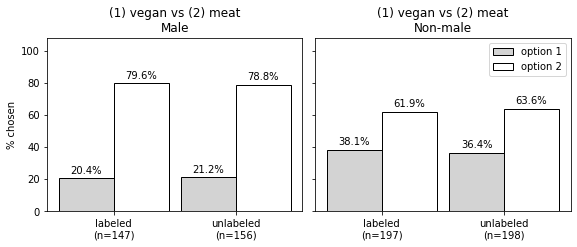

3: (1) vegetarian vs (2) vegetarian


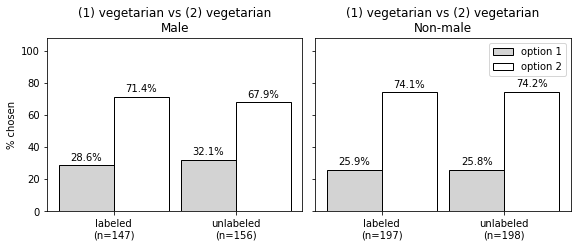

4: (1) vegan vs (2) vegan


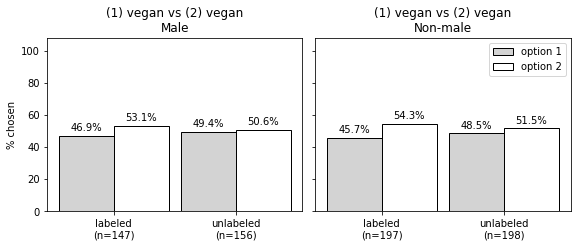

5: (1) vegan vs (2) vegetarian


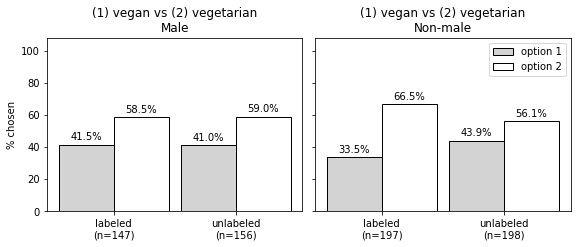

In [80]:
for choice_type, name in plot_choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    male_cdf = male_choices_df[male_choices_df['choice_type']==choice_type]
    nonmale_cdf = nonmale_choices_df[nonmale_choices_df['choice_type']==choice_type]
    fig,axes = plt.subplots(1,2, figsize=(2*figsize[0],figsize[1]), sharey=True)#, dpi=300)
    plt.tight_layout()
    for i, (g, df) in enumerate([('Male',male_cdf),('Non-male', nonmale_cdf),]):
        ax = axes[i]
        ax.set_title(g)
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(
            contingency_df, ax, 
            ylabel=(True if i==0 else False), legend=(True if i>0 else False)
        )
        ax.set_title('%s\n%s'%(name, g))
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Test impact of label removal on vegetarians/vegans

Does removing labels impact vegetarians and vegans?

In [81]:
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,is_vegetarian,is_vegan
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0,1,1
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0,1,0


In [82]:
for choice_type in [1,2]:
    print('\nchoice type %s : %s\n' % (choice_type, choices_type_names_dict[choice_type]))
    vcdf = veg_choices_df[veg_choices_df['choice_type']==choice_type]
    vc_contingency_df = make_contingency_df(vcdf).apply(round, args=([2]))
    #fig,ax = plt.subplots(figsize=(4,3))
    # plot_contingency_table(vc_contingency_df, ax)
    #plt.show()
    print(vc_contingency_df.drop(['expected'],axis=1))


choice type 1 : 1=(labeled) vegetarian vs 0=meat

        labeled  unlabeled  % labeled  % unlabeled
choice                                            
0             2          1       0.06         0.04
1            33         25       0.94         0.96
total        35         26       1.00         1.00

choice type 2 : 1=(labeled) vegan vs 0=meat

        labeled  unlabeled  % labeled  % unlabeled
choice                                            
0             4          2       0.11         0.08
1            31         24       0.89         0.92
total        35         26       1.00         1.00


In [83]:
choice_type = 5
print('\nchoice type %s : %s\n' % (choice_type, choices_type_names_dict[choice_type]))
vcdf = veg_choices_df[veg_choices_df['choice_type']==choice_type]
vcdf = vcdf[vcdf['is_vegan']>0]
vc_contingency_df = make_contingency_df(vcdf).apply(round, args=([2]))
vc_contingency_df.drop(['expected'], axis=1)


choice type 5 : 1=(labeled) vegan vs 0=vegetarian



,labeled,unlabeled,% labeled,% unlabeled
choice,,,,
0,0.0,1.0,0.0,0.14
1,6.0,6.0,1.0,0.86
total,6.0,7.0,1.0,1.00


1 of 7 vegans in the unlabeled group chose vegetarian instead of vegan.

0 of 6 vegans in the labeled group chose vegetarian instead of vegan.

A chi-squared test does not find this statistically significant.

In [84]:
chisq, p = scipy.stats.chisquare(vc_contingency_df['labeled'], vc_contingency_df['expected'])
print('chisq=%0.3f; p=%0.3f'%(chisq,p))

chisq=1.004; p=0.605


### Logistic Regressions


Just choice type 5

In [85]:
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c5df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670591
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      696
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                0.002555
Time:                        23:40:04   Log-Likelihood:                -468.07
converged:                       True   LL-Null:                       -469.27
Covariance Type:            nonrobust   LLR p-value:                    0.1215
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2959      0.107     -2.754      0.006      -0.507      -0.085
labeled       -0.2398      0.

In [86]:
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    choice_type_model = smf.logit(eq, data=cdf).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.608536
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      696
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                0.004996
Time:                        23:40:04   Log-Likelihood:                -424.76
converged:                       True   LL-Null:                       -426.89
Covariance Type:            nonrobust   LLR p-value:                   0.03890
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6805      0.113     -6.048      0.000      -0.901      

In [87]:
# Considering the impact of gender
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + gender"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    choice_type_model = smf.logit(eq, data=cdf).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.598399
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                 0.02157
Time:                        23:40:04   Log-Likelihood:                -417.68
converged:                       True   LL-Null:                       -426.89
Covariance Type:            nonrobust   LLR p-value:                 0.0001002
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7357      0.115     -6.373      0.000      -0.962      

### Multilevel modeling


We use a hierarchical logistic regression model, where choices from all choice types are included in the model, and the participant-level effect is controlled for.

In [88]:
from pymer4.models import Lmer
# Lme4 Random Effects Cheat Sheet: http://eshinjolly.com/pymer4/rfx_cheatsheet.html

#### Vegan choice types

In [89]:
vegan_choice_types = [2,4,5]

In [90]:
print('Vegan choice types only')
Lmer(
    "choice ~ labeled + male + male:option_w_meat + male:option_w_meat:labeled + (labeled|ResponseId)", 
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)],
    family="binomial"
).fit()

Vegan choice types only
Formula: choice~labeled+male+male:option_w_meat+male:option_w_meat:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1360.668 	 AIC: 2737.336

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.369  0.607
ResponseId      labeled  0.564  0.751

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.283

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.334,-0.510,-0.159,0.090,0.716,0.600,0.853,0.417,0.375,0.460,-3.732,0.000,***
labeled,-0.151,-0.381,0.079,0.117,0.860,0.683,1.082,0.462,0.406,0.520,-1.286,0.198,
male,0.165,-0.071,0.400,0.120,1.179,0.932,1.492,0.541,0.482,0.599,1.372,0.170,
male:option_w_meat,-1.244,-1.693,-0.795,0.229,0.288,0.184,0.452,0.224,0.155,0.311,-5.427,0.000,***
labeled:male:option_w_meat,-0.005,-0.639,0.628,0.323,0.995,0.528,1.875,0.499,0.346,0.652,-0.016,0.987,


In [91]:
print('Vegan choice types only')
Lmer(
    "choice ~ labeled + male:option_w_meat + top_1_priority_filling + top_1_priority_filling:labeled + (labeled|ResponseId)", 
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)],
    family="binomial"
).fit()

Vegan choice types only
Formula: choice~labeled+male:option_w_meat+top_1_priority_filling+top_1_priority_filling:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1361.318 	 AIC: 2738.637

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.367  0.606
ResponseId      labeled  0.570  0.755

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.28

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.277,-0.429,-0.125,0.078,0.758,0.651,0.883,0.431,0.394,0.469,-3.566,0.000,***
labeled,-0.142,-0.367,0.082,0.115,0.867,0.693,1.086,0.464,0.409,0.521,-1.241,0.214,
top_1_priority_filling,0.084,-0.713,0.880,0.406,1.087,0.490,2.411,0.521,0.329,0.707,0.206,0.837,
male:option_w_meat,-1.160,-1.477,-0.843,0.162,0.314,0.228,0.431,0.239,0.186,0.301,-7.165,0.000,***
labeled:top_1_priority_filling,-0.528,-1.966,0.909,0.733,0.590,0.140,2.482,0.371,0.123,0.713,-0.721,0.471,


#### All choice types

In [92]:
m = Lmer("choice ~ labeled + (labeled|ResponseId)", data=choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2236.804 	 AIC: 4483.607

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.226  0.475
ResponseId      labeled  0.551  0.743

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.27

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.577,-0.690,-0.464,0.058,0.562,0.502,0.629,0.360,0.334,0.386,-9.986,0.000,***
labeled,-0.204,-0.383,-0.026,0.091,0.815,0.682,0.975,0.449,0.405,0.494,-2.242,0.025,*


In [93]:
eq = "choice ~ labeled + (1|ResponseId)"
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2239.251 	 AIC: 4484.501

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.387  0.622

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.596,-0.717,-0.475,0.062,0.551,0.488,0.622,0.355,0.328,0.383,-9.645,0.000,***
labeled,-0.157,-0.329,0.015,0.088,0.855,0.719,1.015,0.461,0.418,0.504,-1.789,0.074,.


In [94]:
eq = "choice ~ labeled + (labeled|ResponseId) + (1|choice_type)"
Lmer(eq, data=choices_df, family="binomial").fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+(labeled|ResponseId)+(1|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2200.341 	 AIC: 4412.681

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.262  0.512
ResponseId       labeled  0.282  0.531
choice_type  (Intercept)  0.119  0.345

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled  0.197

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.593,-0.917,-0.269,0.165,0.553,0.400,0.764,0.356,0.286,0.433,-3.590,0.000,***
labeled,-0.210,-0.393,-0.027,0.093,0.810,0.675,0.973,0.448,0.403,0.493,-2.254,0.024,*


In [95]:
eq = "choice ~ labeled + (labeled|ResponseId) + (labeled|choice_type)"
Lmer(eq, data=choices_df, family="binomial").fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2200.327 	 AIC: 4416.654

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.261  0.511
ResponseId       labeled  0.365  0.604
choice_type  (Intercept)  0.115  0.339
choice_type      labeled  0.000  0.012

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled  0.046
choice_type  (Intercept)  labeled  1.000

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.593,-0.912,-0.273,0.163,0.553,0.402,0.761,0.356,0.287,0.432,-3.639,0.000,***
labeled,-0.212,-0.396,-0.028,0.094,0.809,0.673,0.972,0.447,0.402,0.493,-2.257,0.024,*


In [96]:
m = Lmer("choice ~ labeled + gender + (labeled + gender|ResponseId)", data=choices_df, family="binomial")
m.fit()

Formula: choice~labeled+gender+(labeled+gender|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2231.899 	 AIC: 4481.799

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.096  0.310
ResponseId      labeled  0.551  0.742
ResponseId       gender  0.407  0.638

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.263
ResponseId  (Intercept)   gender -0.662
ResponseId      labeled   gender  0.678

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.586,-0.698,-0.474,0.057,0.557,0.498,0.623,0.358,0.332,0.384,-10.262,0.000,***
labeled,-0.216,-0.395,-0.036,0.091,0.806,0.674,0.964,0.446,0.403,0.491,-2.359,0.018,*
gender,-0.212,-0.389,-0.035,0.090,0.809,0.678,0.965,0.447,0.404,0.491,-2.350,0.019,*


In [97]:
# Coding gender with 'male'
eq = "choice ~ labeled + male + (labeled|ResponseId)"
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2233.888 	 AIC: 4479.776

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.211  0.459
ResponseId      labeled  0.564  0.751

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.274

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.483,-0.617,-0.348,0.069,0.617,0.540,0.706,0.382,0.350,0.414,-7.029,0.000,***
labeled,-0.209,-0.387,-0.031,0.091,0.811,0.679,0.970,0.448,0.404,0.492,-2.299,0.021,*
male,-0.212,-0.385,-0.040,0.088,0.809,0.681,0.961,0.447,0.405,0.490,-2.418,0.016,*


Use choice specific data

In [98]:
eq = (
    "choice ~ labeled + gender + option_w_meat + option_w_meat:gender"
    "+ option_w_meat:labeled:gender + (labeled|ResponseId)"
)
m = Lmer(eq, data=choices_df, family="binomial")
m.fit()

Formula: choice~labeled+gender+option_w_meat+option_w_meat:gender+option_w_meat:labeled:gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.319 	 AIC: 4424.637

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.239  0.489
ResponseId      labeled  0.532  0.729

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.191

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.413,-0.541,-0.285,0.065,0.662,0.582,0.752,0.398,0.368,0.429,-6.313,0.000,***
labeled,-0.212,-0.396,-0.028,0.094,0.809,0.673,0.972,0.447,0.402,0.493,-2.258,0.024,*
gender,0.116,-0.092,0.325,0.106,1.123,0.912,1.384,0.529,0.477,0.581,1.093,0.274,
option_w_meat,-0.491,-0.647,-0.335,0.080,0.612,0.523,0.716,0.380,0.344,0.417,-6.156,0.000,***
gender:option_w_meat,-0.913,-1.309,-0.518,0.202,0.401,0.270,0.596,0.286,0.213,0.373,-4.530,0.000,***
labeled:gender:option_w_meat,0.006,-0.515,0.527,0.266,1.006,0.598,1.693,0.501,0.374,0.629,0.022,0.982,


In [99]:
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male"
    "+ (labeled|ResponseId) + (labeled|choice_type)"
)
m = Lmer(eq, data=choices_df, family="binomial")
m.fit()


boundary (singular) fit: see ?isSingular 

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2179.813 	 AIC: 4381.625

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.263  0.513
ResponseId       labeled  0.436  0.660
choice_type  (Intercept)  0.081  0.285
choice_type      labeled  0.000  0.005

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled -0.025
choice_type  (Intercept)  labeled  1.000

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.488,-0.849,-0.126,0.185,0.614,0.428,0.882,0.380,0.300,0.469,-2.643,0.008,**
labeled,-0.217,-0.403,-0.032,0.094,0.805,0.669,0.968,0.446,0.401,0.492,-2.300,0.021,*
male,0.120,-0.092,0.332,0.108,1.128,0.912,1.394,0.530,0.477,0.582,1.109,0.267,
option_w_meat,-0.018,-0.574,0.538,0.283,0.982,0.563,1.712,0.495,0.360,0.631,-0.064,0.949,
male:option_w_meat,-0.922,-1.235,-0.608,0.160,0.398,0.291,0.544,0.285,0.225,0.352,-5.768,0.000,***


In [100]:
eq = (
    "choice ~ labeled + male + option_w_meat + option_w_meat:male + male:labeled"
    "+ option_w_meat:labeled+ option_w_meat:male:labeled + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.00891557 (tol = 0.001, component 1) 

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+male:labeled+option_w_meat:labeled+option_w_meat:male:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.084 	 AIC: 4428.167

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.236  0.486
ResponseId      labeled  0.544  0.737

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.198

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.456,-0.639,-0.273,0.094,0.634,0.528,0.761,0.388,0.345,0.432,-4.879,0.000,***
labeled,-0.249,-0.531,0.033,0.144,0.780,0.588,1.033,0.438,0.370,0.508,-1.732,0.083,.
male,0.063,-0.211,0.337,0.140,1.065,0.810,1.400,0.516,0.448,0.583,0.451,0.652,
option_w_meat,-0.034,-0.302,0.234,0.137,0.967,0.740,1.264,0.492,0.425,0.558,-0.246,0.806,
male:option_w_meat,-0.859,-1.284,-0.433,0.217,0.424,0.277,0.649,0.298,0.217,0.393,-3.952,0.000,***
labeled:male,0.127,-0.295,0.550,0.216,1.136,0.744,1.733,0.532,0.427,0.634,0.590,0.555,
labeled:option_w_meat,-0.005,-0.395,0.386,0.199,0.995,0.674,1.471,0.499,0.402,0.595,-0.023,0.982,
labeled:male:option_w_meat,-0.114,-0.741,0.513,0.320,0.892,0.477,1.670,0.472,0.323,0.626,-0.357,0.721,


In [101]:
eq = (
    "choice ~ labeled + male + option_w_meat + option_w_meat:male + male:labeled"
    "+ option_w_meat:labeled+ option_w_meat:male:labeled"
    "+ (labeled|ResponseId) + (labeled|choice_type)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+male:labeled+option_w_meat:labeled+option_w_meat:male:labeled+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2179.579 	 AIC: 4387.158

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.262  0.512
ResponseId       labeled  0.414  0.643
choice_type  (Intercept)  0.081  0.285
choice_type      labeled  0.000  0.008

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled  0.010
choice_type  (Intercept)  labeled  0.511

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.474,-0.847,-0.102,0.190,0.622,0.429,0.903,0.384,0.300,0.475,-2.494,0.013,*
labeled,-0.252,-0.540,0.035,0.147,0.777,0.583,1.036,0.437,0.368,0.509,-1.721,0.085,.
male,0.067,-0.212,0.346,0.142,1.069,0.809,1.413,0.517,0.447,0.586,0.469,0.639,
option_w_meat,-0.022,-0.599,0.554,0.294,0.978,0.550,1.740,0.494,0.355,0.635,-0.076,0.940,
male:option_w_meat,-0.863,-1.290,-0.437,0.218,0.422,0.275,0.646,0.297,0.216,0.393,-3.966,0.000,***
labeled:male,0.132,-0.299,0.562,0.220,1.141,0.742,1.755,0.533,0.426,0.637,0.600,0.548,
labeled:option_w_meat,0.003,-0.390,0.396,0.201,1.003,0.677,1.486,0.501,0.404,0.598,0.016,0.987,
labeled:male:option_w_meat,-0.130,-0.758,0.499,0.321,0.878,0.468,1.647,0.468,0.319,0.622,-0.404,0.686,


In [102]:
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.319 	 AIC: 4422.637

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.239  0.489
ResponseId      labeled  0.541  0.735

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.202

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.471,-0.628,-0.314,0.080,0.624,0.534,0.731,0.384,0.348,0.422,-5.870,0.000,***
labeled,-0.212,-0.394,-0.030,0.093,0.809,0.674,0.970,0.447,0.403,0.492,-2.288,0.022,*
option_w_meat,-0.036,-0.231,0.159,0.099,0.965,0.794,1.173,0.491,0.443,0.540,-0.360,0.719,
male,0.116,-0.092,0.324,0.106,1.123,0.912,1.383,0.529,0.477,0.580,1.094,0.274,
option_w_meat:male,-0.911,-1.223,-0.598,0.159,0.402,0.294,0.550,0.287,0.227,0.355,-5.712,0.000,***


With demographic covariates

In [103]:
# Adding in demographics
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male"
    "+ age + income + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.0104269 (tol = 0.001, component 1) 

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+age+income+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2195.286 	 AIC: 4428.571

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.251  0.501
ResponseId      labeled  0.585  0.765

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.392

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.705,-1.014,-0.395,0.158,0.494,0.363,0.674,0.331,0.266,0.403,-4.461,0.000,***
labeled,-0.197,-0.377,-0.018,0.092,0.821,0.686,0.983,0.451,0.407,0.496,-2.151,0.031,*
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.359,0.720,
male,0.080,-0.130,0.291,0.107,1.084,0.878,1.337,0.520,0.468,0.572,0.748,0.455,
age3,0.060,-0.174,0.294,0.119,1.062,0.840,1.341,0.515,0.457,0.573,0.500,0.617,
age4,0.091,-0.185,0.366,0.140,1.095,0.831,1.441,0.523,0.454,0.590,0.645,0.519,
age5,0.198,-0.135,0.531,0.170,1.219,0.874,1.700,0.549,0.466,0.630,1.165,0.244,
age6,0.499,0.118,0.881,0.194,1.648,1.126,2.413,0.622,0.530,0.707,2.568,0.010,*
age7,0.597,0.151,1.043,0.228,1.817,1.163,2.838,0.645,0.538,0.739,2.624,0.009,**
income2,0.056,-0.266,0.378,0.164,1.058,0.767,1.459,0.514,0.434,0.593,0.342,0.732,


##### Test impact of hunger level

In [104]:
eq = "choice ~ labeled + current_hunger + labeled:current_hunger + (1|ResponseId)"
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+current_hunger+labeled:current_hunger+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2238.916 	 AIC: 4487.833

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.385  0.621

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.525,-0.868,-0.182,0.175,0.592,0.420,0.834,0.372,0.296,0.455,-3.000,0.003,**
labeled,-0.114,-0.599,0.371,0.248,0.892,0.549,1.450,0.472,0.354,0.592,-0.460,0.645,
current_hunger,-0.031,-0.172,0.110,0.072,0.969,0.842,1.116,0.492,0.457,0.527,-0.432,0.665,
labeled:current_hunger,-0.018,-0.215,0.179,0.101,0.982,0.807,1.196,0.496,0.446,0.545,-0.177,0.860,


##### Test by priorities

In [105]:
codebook['Q_priorities']['choices']

{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}

Priority: Health

For just choice 5

In [106]:
eq = (
    "choice ~ labeled + priority_health"
)
c_df = choices_df[choices_df.choice_type == 5] # vegan vs vegetarian
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.664213
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                 0.01204
Time:                        23:57:04   Log-Likelihood:                -463.62
converged:                       True   LL-Null:                       -469.27
Covariance Type:            nonrobust   LLR p-value:                  0.003515
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2143      0.111     -1.925      0.054      -0.433       0.004
labeled       

In [107]:
eq = (
    "choice ~ labeled + top_1_priority_health + option_w_meat"
    "+ male:option_w_meat"
    "+ top_1_priority_health:labeled"
    "+ top_1_priority_health:option_w_meat"
    "+ top_1_priority_health:labeled:option_w_meat"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+top_1_priority_health+option_w_meat+male:option_w_meat+top_1_priority_health:labeled+top_1_priority_health:option_w_meat+top_1_priority_health:labeled:option_w_meat+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2183.359 	 AIC: 4388.717

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.215  0.463
ResponseId      labeled  0.606  0.779

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.318

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.432,-0.563,-0.301,0.067,0.649,0.570,0.740,0.394,0.363,0.425,-6.461,0.000,***
labeled,-0.253,-0.442,-0.063,0.097,0.777,0.643,0.939,0.437,0.391,0.484,-2.617,0.009,**
top_1_priority_health,0.431,-0.094,0.957,0.268,1.539,0.910,2.603,0.606,0.477,0.722,1.609,0.108,
option_w_meat,-0.156,-0.342,0.031,0.095,0.856,0.710,1.031,0.461,0.415,0.508,-1.638,0.101,
option_w_meat:male,-0.861,-1.131,-0.591,0.138,0.423,0.323,0.554,0.297,0.244,0.356,-6.243,0.000,***
labeled:top_1_priority_health,-0.048,-0.785,0.688,0.376,0.953,0.456,1.990,0.488,0.313,0.666,-0.129,0.897,
top_1_priority_health:option_w_meat,0.698,-0.080,1.475,0.397,2.009,0.923,4.373,0.668,0.480,0.814,1.759,0.079,.
labeled:top_1_priority_health:option_w_meat,0.607,-0.415,1.629,0.521,1.835,0.660,5.097,0.647,0.398,0.836,1.164,0.244,


In [108]:
choices_df['priority_health'].describe()

count    3490.000000
mean       -0.353868
std         1.234589
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: priority_health, dtype: float64

For all choices

In [109]:
eq = (
    "choice ~ labeled + priority_health + option_w_meat + priority_health:labeled"
    " + male:option_w_meat + priority_health:labeled:option_w_meat + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.00100983 (tol = 0.001, component 1) 

Formula: choice~labeled+priority_health+option_w_meat+priority_health:labeled+male:option_w_meat+priority_health:labeled:option_w_meat+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2186.077 	 AIC: 4392.154

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.211  0.459
ResponseId      labeled  0.558  0.747

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.277

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.362,-0.493,-0.230,0.067,0.697,0.611,0.794,0.411,0.379,0.443,-5.396,0.000,***
labeled,-0.229,-0.413,-0.045,0.094,0.796,0.662,0.956,0.443,0.398,0.489,-2.437,0.015,*
priority_health,0.142,0.052,0.233,0.046,1.153,1.053,1.263,0.536,0.513,0.558,3.075,0.002,**
option_w_meat,-0.059,-0.241,0.123,0.093,0.943,0.786,1.131,0.485,0.440,0.531,-0.632,0.527,
labeled:priority_health,-0.016,-0.172,0.140,0.080,0.984,0.842,1.150,0.496,0.457,0.535,-0.204,0.838,
option_w_meat:male,-0.820,-1.086,-0.553,0.136,0.441,0.337,0.575,0.306,0.252,0.365,-6.029,0.000,***
labeled:priority_health:option_w_meat,0.287,0.103,0.470,0.094,1.332,1.109,1.600,0.571,0.526,0.615,3.066,0.002,**


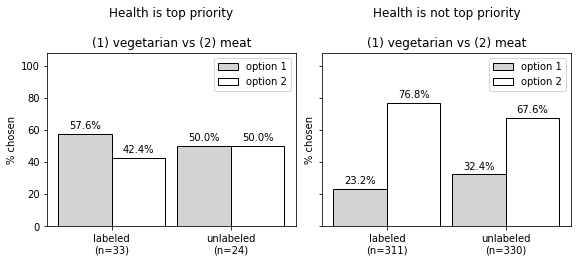

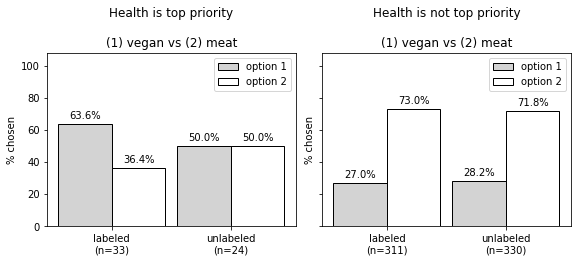

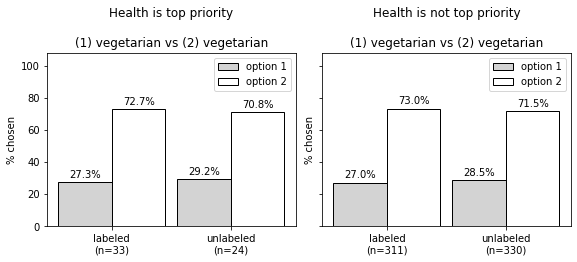

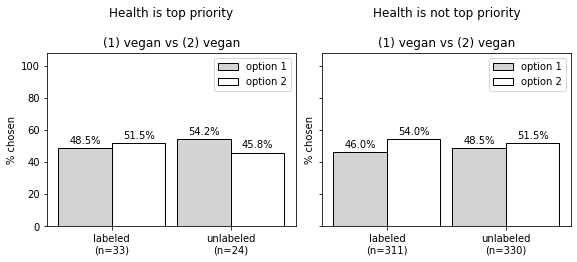

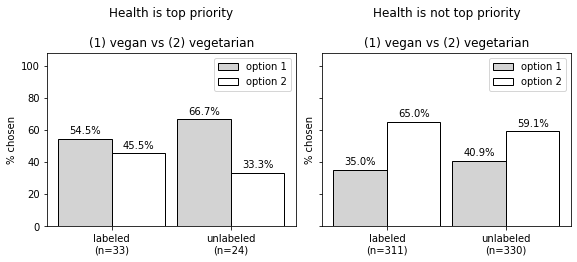

In [110]:
for choice_type, name in plot_choices_type_names_dict.items():
    cdf = choices_df[choices_df['choice_type']==choice_type]
    yes_prioritize_health_df = cdf[cdf['top_1_priority_health'] > 0]
    no_prioritize_health_df = cdf[cdf['top_1_priority_health'] < 1]
    fig,axes = plt.subplots(1,2, figsize=(8,3), sharey=True)
    plt.tight_layout()
    for i, (g, df) in enumerate([('Health is top priority',yes_prioritize_health_df),('Health is not top priority',no_prioritize_health_df),]):
        ax = axes[i]
        ax.set_title('%s\n\n%s'%(g, name))
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(contingency_df, ax)
    plt.show()

1: 1=(labeled) vegetarian vs 0=meat


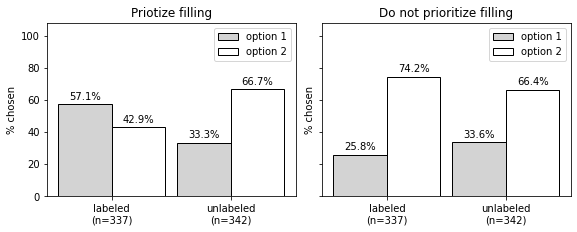

2: 1=(labeled) vegan vs 0=meat


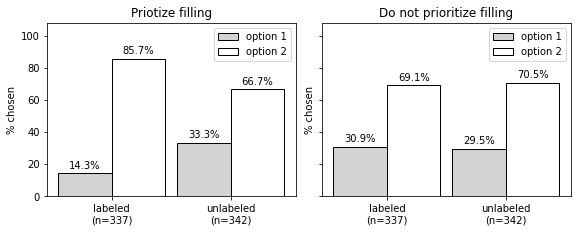

3: 1=(labeled) vegetarian vs 0=vegetarian


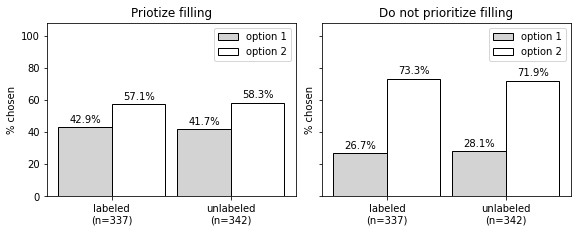

4: 1=(labeled) vegan vs 0=vegan


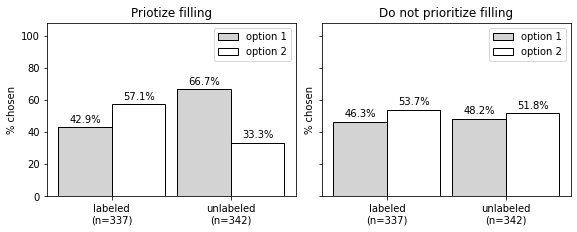

5: 1=(labeled) vegan vs 0=vegetarian


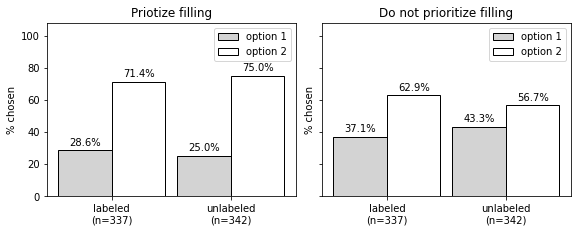

In [111]:
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, choices_type_names_dict[choice_type]))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    yes_prioritize_df = cdf[cdf['top_1_priority_filling'] > 0]
    no_prioritize_df = cdf[cdf['top_1_priority_filling'] < 1]
    fig,axes = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
    plt.tight_layout()
    for i, (g, df) in enumerate([('Priotize filling',yes_prioritize_df),('Do not prioritize filling',no_prioritize_df),]):
        ax = axes[i]
        ax.set_title(g)
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(contingency_df, ax)
    plt.show()

In [112]:
eq = (
    "choice ~ labeled + gender + (labeled|ResponseId)"
    "+ priority_health + priority_taste + priority_filling + priority_usual_choice"
    "+ priority_health:labeled"
    "+ priority_taste:labeled + priority_filling:labeled + priority_usual_choice:labeled"
)
print(Lmer(eq, data=choices_df, family="binomial").fit())

Model failed to converge with max|grad| = 0.0151958 (tol = 0.001, component 1) 

Formula: choice~labeled+gender+(labeled|ResponseId)+priority_health+priority_taste+priority_filling+priority_usual_choice+priority_health:labeled+priority_taste:labeled+priority_filling:labeled+priority_usual_choice:labeled

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2215.132 	 AIC: 4458.264

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.165  0.406
ResponseId      labeled  0.530  0.728

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.324

Fixed effects:

                               Estimate  2.5_ci  97.5_ci     SE     OR  \
(Intercept)                      -0.356  -0.628   -0.084  0.139  0.701   
labeled                          -0.254  -0.682    0.174  0.218  0.776   
gender                           -0.240  -0.410   -0.070  0.087  0.787   
priority_health         

In [113]:
print('Vegan choice types only')
for pkey, pname in codebook['Q_priorities']['choices'].items():
    print('\n----------- priority %s: %s -----------\n' % (pkey, pname))
    eq = (
        "choice ~ labeled + priority_%s  + priority_%s:labeled + gender + (labeled|ResponseId)"%(pname, pname)
    )
    print(Lmer(eq, data=choices_df[choices_df.choice_type.isin(vegan_choice_types)], family="binomial").fit())
    

Vegan choice types only

----------- priority 1: health -----------

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+priority_health+priority_health:labeled+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1377.458 	 AIC: 2770.916

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.262  0.512
ResponseId      labeled  0.598  0.774

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.469

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                -0.357  -0.505   -0.209  0.076  0.700      0.603   
labeled                    -0.156  -0.373    0.061  0.111  0.856      0.689   
priority_health             0.162   0.049    0.274  0.058  1.175      1.050   
gender                     -0.200  

In [114]:
print('check w. choice_vegan')
for pkey, pname in codebook['Q_priorities']['choices'].items():
    print('\n----------- priority %s: %s -----------\n' % (pkey, pname))
    eq = (
        "choice ~ labeled + priority_%s  + choice_vegan + priority_%s:labeled + priority_%s:labeled:choice_vegan + gender + (labeled|ResponseId)"%(pname, pname, pname)
    )
    print(Lmer(eq, data=choices_df, family="binomial").fit())
    

check w. choice_vegan

----------- priority 1: health -----------

Formula: choice~labeled+priority_health+choice_vegan+priority_health:labeled+priority_health:labeled:choice_vegan+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2199.232 	 AIC: 4418.463

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.206  0.453
ResponseId      labeled  0.573  0.757

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.335

Fixed effects:

                                      Estimate  2.5_ci  97.5_ci     SE     OR  \
(Intercept)                             -0.839  -0.993   -0.685  0.078  0.432   
labeled                                 -0.217  -0.399   -0.035  0.093  0.805   
priority_health                          0.141   0.051    0.231  0.046  1.151   
choice_vegan                             0.506   0.353    0.658  0.078  1.658   
gender     

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+priority_usual_choice+choice_vegan+priority_usual_choice:labeled+priority_usual_choice:labeled:choice_vegan+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2206.852 	 AIC: 4433.705

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.204  0.452
ResponseId      labeled  0.522  0.723

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.164

Fixed effects:

                                            Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                   -0.966  -1.130   -0.801  0.084   
labeled                                       -0.178  -0.381    0.025  0.104   
priority_usual_choice                         -0.132  -0.219   -0.045  0.045   
choice_vegan                    

Test sentiments about environment and whether vegetarian/vegan dishes are good for the environment.

Separate the population into people who agree veg dishes are good for the environment and those who do not.

In [115]:
veg_good_choices_df = choices_df[choices_df['veg_good_for_env']==1]
not_veg_good_choices_df = choices_df[choices_df['veg_good_for_env']==0]
print(len(choices_df))
print(len(veg_good_choices_df))
print(len(not_veg_good_choices_df))
not_veg_good_choices_df.head()

3490
2380
1110


,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan,gender,male,...,priority_health,priority_cost,priority_taste,priority_filling,priority_usual_choice,top_1_priority_health,top_1_priority_cost,top_1_priority_taste,top_1_priority_filling,top_1_priority_usual_choice
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,0,2,1,-1,-2,0,1,0,0,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,2,-2,1,-1,0,1,0,0,0,0
12,R_30rbJTBzyanldWc,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,-2,0,2,1,-1,0,0,1,0,0
14,R_2WBvDkGf61dghtw,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,1,-1,2,0,-2,0,0,1,0,0
21,R_3wLkXI2zKmZFfmF,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,-2,1,2,-1,0,0,0,1,0,0


In [116]:
# Start with choice type 5:
c_df = not_veg_good_choices_df[not_veg_good_choices_df.choice_type == 5]
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670200
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  222
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                0.001971
Time:                        00:06:40   Log-Likelihood:                -148.78
converged:                       True   LL-Null:                       -149.08
Covariance Type:            nonrobust   LLR p-value:                    0.4433
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3145      0.194     -1.622      0.105      -0.695       0.066
labeled       -0.2105      0.

In [117]:
# Start with choice type 5:
c_df = veg_good_choices_df[veg_good_choices_df.choice_type == 5]
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670754
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  476
Model:                          Logit   Df Residuals:                      474
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                0.002847
Time:                        00:06:40   Log-Likelihood:                -319.28
converged:                       True   LL-Null:                       -320.19
Covariance Type:            nonrobust   LLR p-value:                    0.1769
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2877      0.129     -2.228      0.026      -0.541      -0.035
labeled       -0.2533      0.

In [118]:
eq = (
    "choice ~ labeled + env_is_important"
    "+ env_is_important:labeled" 
    "+ (1|ResponseId)"
)
Lmer(
    eq,
    data=choices_df, 
    family="binomial"
).fit()

Formula: choice~labeled+env_is_important+env_is_important:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2237.320 	 AIC: 4484.640

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.379  0.615

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.865,-1.164,-0.567,0.152,0.421,0.312,0.567,0.296,0.238,0.362,-5.681,0.000,***
labeled,0.137,-0.268,0.541,0.206,1.147,0.765,1.719,0.534,0.433,0.632,0.663,0.507,
env_is_important,0.323,-0.002,0.648,0.166,1.381,0.998,1.912,0.580,0.500,0.657,1.949,0.051,.
labeled:env_is_important,-0.353,-0.800,0.094,0.228,0.703,0.449,1.099,0.413,0.310,0.524,-1.547,0.122,


In [119]:
eq = (
    "choice ~ labeled + veg_good_for_env"
    "+ veg_good_for_env:labeled"
    "+ (1|ResponseId)"
)
Lmer(
    eq,
    data=choices_df, 
    family="binomial"
).fit()

Formula: choice~labeled+veg_good_for_env+veg_good_for_env:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2233.101 	 AIC: 4476.202

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.367  0.606

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.831,-1.052,-0.610,0.113,0.436,0.349,0.543,0.303,0.259,0.352,-7.381,0.000,***
labeled,-0.141,-0.452,0.169,0.158,0.868,0.637,1.184,0.465,0.389,0.542,-0.893,0.372,
veg_good_for_env,0.339,0.077,0.600,0.133,1.403,1.080,1.822,0.584,0.519,0.646,2.540,0.011,*
labeled:veg_good_for_env,-0.013,-0.384,0.359,0.190,0.987,0.681,1.432,0.497,0.405,0.589,-0.067,0.947,


In [120]:
eq = (
    "choice ~ labeled + (labeled|ResponseId)"
)
Lmer(eq, data=veg_good_choices_df, family="binomial").fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2380	 Groups: {'ResponseId': 476.0}

Log-likelihood: -1557.390 	 AIC: 3124.780

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.178  0.422
ResponseId      labeled  0.544  0.738

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.309

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.473,-0.604,-0.343,0.067,0.623,0.547,0.710,0.384,0.353,0.415,-7.109,0.000,***
labeled,-0.193,-0.401,0.015,0.106,0.824,0.669,1.015,0.452,0.401,0.504,-1.817,0.069,.


In [121]:
eq = (
    "choice ~ labeled + (labeled|ResponseId)"
)
Lmer(eq, data=not_veg_good_choices_df, family="binomial").fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 1110	 Groups: {'ResponseId': 222.0}

Log-likelihood: -672.988 	 AIC: 1355.975

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.285  0.534
ResponseId      labeled  0.592  0.769

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.275

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.818,-1.038,-0.597,0.112,0.442,0.354,0.550,0.306,0.262,0.355,-7.277,0.000,***
labeled,-0.206,-0.546,0.133,0.173,0.814,0.579,1.143,0.449,0.367,0.533,-1.190,0.234,


Test impact of people agreeing that "vegan dishes are not for me".

Limit analysis to choice types with vegan options (2,4,5)

In [122]:
eq = "choice ~ labeled + vegan_not_me + vegan_not_me:labeled + (1|ResponseId)"
Lmer(
    eq,
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)], 
    family="binomial"
).fit()

Formula: choice~labeled+vegan_not_me+vegan_not_me:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1381.363 	 AIC: 2772.726

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.382  0.618

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.317,-0.486,-0.148,0.086,0.728,0.615,0.863,0.421,0.381,0.463,-3.667,0.000,***
labeled,-0.059,-0.297,0.179,0.121,0.943,0.743,1.196,0.485,0.426,0.545,-0.485,0.628,
vegan_not_me,-0.391,-0.713,-0.068,0.165,0.677,0.490,0.935,0.404,0.329,0.483,-2.371,0.018,*
labeled:vegan_not_me,-0.308,-0.787,0.171,0.244,0.735,0.455,1.187,0.424,0.313,0.543,-1.259,0.208,


In [123]:
for choice_type in vegan_choice_types:
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    eq = "choice ~ labeled + vegan_not_me + vegan_not_me:labeled"
    choice_type_model = smf.logit(eq, data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 2 ( 1=(labeled) vegan vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.592479
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                 0.03125
Time:                        00:07:11   Log-Likelihood:                -413.55
converged:                       True   LL-Null:                       -426.89
Covariance Type:            nonrobust   LLR p-value:                 6.872e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercep

## Comments

The survey comments are fun to read. And informative.

High level notes:
- people do not like onions
- some people do not like olives and pointed out that the vegan/vegetarian options had more olives
- some people did not like any of the menu options
- people did not appreciate that political spectrum was presented on a democrat to republican scale
- many people enjoyed/appreciated the study and said so.
- some people enjoyed the roasted attention check

In [124]:
comments = respondent_df.set_index('ResponseId')['Q_comments'].rename('comments').dropna()

for c in comments.to_list():
    print('"%s"\n'%c)

"I do not lean toward either party. I am a libertarian. Unfortunately, your survey doesn't treat libertarians as if they exist at all."

"None, but thank you!"

"ty"

"no"

"No thanks! "

"Enjoyed the study!"

"In a complex economy vegetarian or "vegan" options are only beneficial if they are produced locally. Since many of us live in climates that do not support year round vegetable agriculture that means most of what veggies consume is from somewhere far away and probably in a place lacking in water. Also, there are far more options than Democrat and Republican. Two sides of the same capitalist coin are not a democracy and the cause of much of the worlds problems."

"Thank you for the study, I answered honestly and to the best of my abilities."

"No"

"could have used a few more attention checks... jk."

"Hope I was helpful"

"No"

"None "

"Enjoyed the survey!"

"no"

"None but I cant eat onions"

"None."

"thanks"

":)"

"No comments "

"You should have option for neither on leanin